In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import uuid  # To generate a unique ID for each file
from tqdm import tqdm
from scipy.sparse import block_diag
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from numpy.linalg import norm
import random
from scipy.linalg import svd, eigh
from joblib import Parallel, delayed
from typing import List, Tuple
import seaborn as sns
import math
from matplotlib.colors import LinearSegmentedColormap
import random
import joblib
import multiprocessing

In [12]:
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 
               'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 
               'chr20', 'chr21', 'chr22', 'chrX']
bins = {
    'chr1': 250,
    'chr2': 244,
    'chr3': 198,
    'chr4': 192,
    'chr5': 181,
    'chr6': 172,
    'chr7': 160,
    'chr8': 147,
    'chr9': 142,
    'chr10': 136,
    'chr11': 135,
    'chr12': 134,
    'chr13': 97,
    'chr14': 89,
    'chr15': 83,
    'chr16': 91,
    'chr17': 82,
    'chr18': 79,
    'chr19': 60,
    'chr20': 63,
    'chr21': 40,
    'chr22': 36,
    'chrX': 154
}



In [13]:
# FUNCTIONS FOR LOADING IN THE MATRICES FROM RAW TXT FILES.
def parse_file(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction'])
    total_sum = data['interaction'].sum()
    cis_contacts = data[data['chr1'] == data['chr2']]['interaction'].sum()
    trans_contacts = data[data['chr1'] != data['chr2']]['interaction'].sum()
    if trans_contacts == 0:
        cis_trans_ratio = float('inf')
    else:
        cis_trans_ratio = cis_contacts / trans_contacts

    if total_sum >= 1000 and cis_trans_ratio >= 1:
        return data
    print(f"SKIPPED {file_path}")
    return None

def find_range(data, chr):
    range_pos1 = data[data['chr1'] == chr]["pos1"]
    range_pos2 = data[data['chr2'] == chr]["pos2"]
    
    max_pos1 = range_pos1.max()
    min_pos1 = range_pos1.min() 
    max_pos2 = range_pos2.max() 
    min_pos2 = range_pos2.min() 

    max_range = max(max_pos1, max_pos2) - min(min_pos1, min_pos2)
    return int(max_range / 1000000) + 1, min(min_pos1, min_pos2)


def load_txt_to_matrix(data):
    list_of_chromosomes = []
    for chr in chromosomes:
        chr_range, min_position = find_range(data, chr)
        X_chr = np.zeros((chr_range, chr_range), dtype=int)

        for _, row in data[(data['chr1'] == chr) & (data['chr2'] == chr)].iterrows():
            if row['interaction'] > 0:
                pos1_index = int((row['pos1'] - min_position) / 1000000)
                pos2_index = int((row['pos2'] - min_position) / 1000000)
                if abs(pos1_index - pos2_index) >= 3:
                    X_chr[pos1_index, pos2_index] = 1
                # else:
                #     X_chr[pos1_index, pos2_index] = -1

        list_of_chromosomes.append(X_chr)
    return list_of_chromosomes

def load_txt_to_matrix_fix_size(data):
    list_of_chromosomes = []
    for chr in chromosomes:
        chr_range, min_position = find_range(data, chr)
        chr_range = bins[chr]
        X_chr = np.zeros((chr_range, chr_range), dtype=int)

        for _, row in data[(data['chr1'] == chr) & (data['chr2'] == chr)].iterrows():
            if row['interaction'] > 0:
                pos1_index = int((row['pos1']-min_position) / 1000000)
                pos2_index = int((row['pos2']-min_position) / 1000000)
                # if abs(pos1_index - pos2_index) >= 3:
                X_chr[pos1_index, pos2_index] = 1
                # else:
                #     X_chr[pos1_index, pos2_index] = -1

        list_of_chromosomes.append(X_chr)
    return list_of_chromosomes

In [ ]:
def load_sampled_files(directory, sample_num):
    all_files = [f for f in os.listdir(directory) if f.endswith('.txt')]
    valid_files = []

    for f in all_files:
        file_path = os.path.join(directory, f)
        data = parse_file(file_path)
        if data is not None:
            valid_files.append(f)
    
    if len(valid_files) < sample_num:
        print(f"Directory {directory} Sample Size Smaller than {sample_num}. Actual Sample Size: {len(valid_files)}")
        sampled_files = valid_files
    else:
        sampled_files = random.sample(valid_files, sample_num)
    
    sample = []
    for file in tqdm(sampled_files, desc=f"Loading samples from {directory}"):
        file_path = os.path.join(directory, file)
        data = parse_file(file_path)
        if data is not None:
            matrix_in_list = load_txt_to_matrix_fix_size(data)
            sample.append(matrix_in_list)
    
    return sample

In [ ]:
sample_num = 40

GM12878_sample = load_sampled_files("GM12878", sample_num)
HAP1_sample = load_sampled_files("HAP1", sample_num)
Hela_sample = load_sampled_files("Hela", sample_num)
K562_sample = load_sampled_files("K562", sample_num)

all_chromosomes = []
for cell_type_sample in [GM12878_sample, HAP1_sample, Hela_sample, K562_sample]:
    for cell in cell_type_sample:
        all_chromosomes.extend(cell)

print(f"Total Loaded {len(all_chromosomes)} Chromosomal Matrices")

警告：目录 GM12878 中有效样本数量少于 40。实际可用样本数量：24


Loading samples from K562: 100%|██████████| 40/40 [00:03<00:00, 11.39it/s]

总共加载了 3312 个染色体矩阵。


In [16]:
# UPDATED FUNCTION FOR TAKING THE APPROXIMATION OF MATRIX C
def approximate_matrix(C, r):
    """
    Approximates the matrix C using rank r approximation via eigendecomposition.

    Parameters:
    C (numpy.ndarray): The input symmetric matrix.
    r (int): The desired rank for the approximation.

    Returns:
    numpy.ndarray: The approximated matrix M of size same as C.
    """
    n = C.shape[0]
    C_full = np.zeros((n, n))
    # Fill upper triangle
    rows, cols = np.triu_indices(n)
    C_full[rows, cols] = C[rows, cols]
    # Fill lower triangle
    C_full = C_full + C_full.T - np.diag(np.diag(C_full))
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(C_full)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Select the top r eigenvalues and eigenvectors
    eigenvalues_r = eigenvalues[:r]
    eigenvectors_r = eigenvectors[:, :r]
    
    # Handle negative eigenvalues (if any) by setting them to 0
    eigenvalues_r = np.maximum(eigenvalues_r, 0)
    
    # Construct X such that M = X*X^T
    X = eigenvectors_r @ np.diag(np.sqrt(eigenvalues_r))
    
    # Reconstruct the matrix M = X*X^T
    M = X @ X.T
    
    # Return only the upper triangular portion
    return np.triu(M)

In [ ]:
def compute_error_chromosome(C, r):
    M = approximate_matrix(C, r)
    diff = C - M
    return np.linalg.norm(diff, 'fro')**2


In [ ]:
def compute_total_error_all_chromosomes(matrix_list, r, n_jobs):
    errors = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(compute_error_chromosome)(C, r) for C in matrix_list
    )
    total_error = np.sum(errors)
    return total_error


In [ ]:
def plot_total_errors_sum(total_errors, r_values):
    plt.figure(figsize=(12, 8))
    plt.plot(r_values, total_errors, label='Total Error', color='white', line_width=2)
    plt.xlabel('Rank of Approximation (r)', fontsize=14)
    plt.ylabel('Total Frobenius Norm Squared of (C - M)', fontsize=14)
    plt.title('Total Error vs Rank of Approximation', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(False)
    plt.tight_layout()
    plt.show()


Using 10 CPU cores for parallel processing.


Processing ranks: 100%|██████████| 250/250 [05:56<00:00,  1.42s/it]


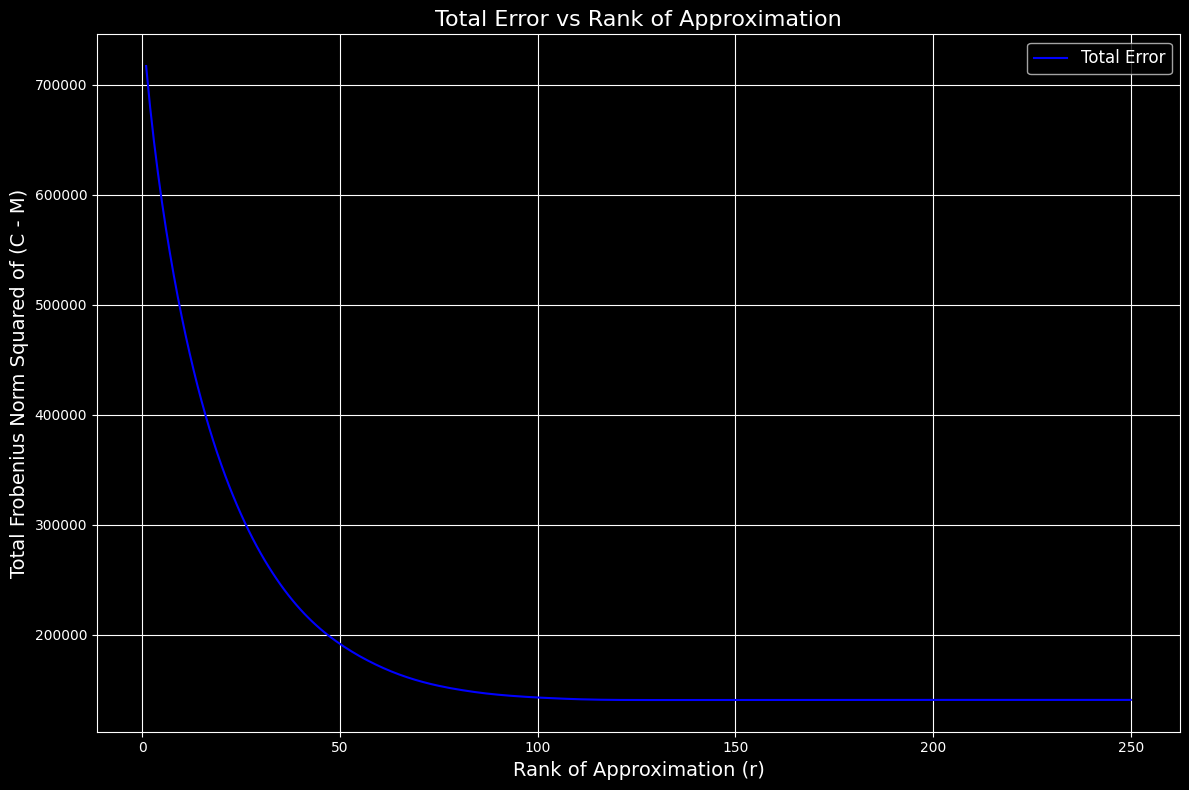

In [20]:
max_rank = 250
r_values = range(1, max_rank + 1, 1)

total_errors_sum = {}
total_errors_sum['Total'] = []

n_jobs = -1

for r in tqdm(r_values, desc="Processing ranks"):
    error = compute_total_error_all_chromosomes(all_chromosomes, r, n_jobs)
    total_errors_sum['Total'].append(error)

plot_total_errors_sum(total_errors_sum['Total'], r_values)